In [1]:
import os
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp

from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib

In [2]:
def get_detection_method_string(detection_method):
    # detection method params
    minimum_duration = 100
    dispersion_threshold = 1.0
    velocity_threshold = 20.0
    
    if detection_method == 'ivt':
        detection_params = {'minimum_duration': minimum_duration,
                            'velocity_threshold': velocity_threshold,
                        }
    elif detection_method == 'idt':
        detection_params = {'minimum_duration': minimum_duration,
                            'dispersion_threshold': dispersion_threshold,
                        }
    elif detection_method == 'microsaccades':
        detection_params = {'minimum_duration': minimum_duration,
                        }
    
    detection_param_string = detection_method + '_'
    for key in detection_params:
        detection_param_string += str(key) + '_' + str(detection_params[key]) + '_'
    detection_param_string = detection_param_string[0:len(detection_param_string)-1]
    return detection_param_string

def avg_tpr_fpr_curve(fprs, tprs, label, plot_random=False,
                title = None, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 10000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = None,
                decimals=3,
                color = None):

    """
    Plot average roc curve from multiple fpr and tpr arrays of multiple cv-folds

    :param fprs: list of fpr arrays for the different folds
    :param tprs: list of tpr arrays for the different folds
    :label: name for the legend
    :plot_random: indicator, indicating if the random guessing curve should be plotted
    :title: title of plot; no title if 'None'
    :plot_statistics: if True, statistics for all the folds are plotted
    :loc: location of legend
    :plot_legend: if True legend is plotted
    :plot_points: number of points to plot
    :ncol: number of columns for legend
    :bbox_to_anchor: bounding box for legend outside of plot
    :starting_point: indicates the starting point of drawing the curves
    :fontsize: fontsize
    :xscale: scale for x-axis
    """
    if xscale is not None:
        plt.xscale(xscale)

    tprs_list = []
    aucs = []
    for i in range(0, len(fprs)):
        fpr = fprs[i]
        tpr = tprs[i]

        tprs_list.append(interpolate.interp1d(fpr, tpr))
        aucs.append(metrics.auc(fprs[i], tprs[i]))
    aucs = np.array(aucs)
    x = np.linspace(0, 1, plot_points)
    if starting_point is not None:
        x = x[x > starting_point]    
        
    if plot_random:
        plt.plot(x,x, color='grey', linestyle='dashed',
                 label='Random guessing')

    # plot average and std error of those roc curves:        
    ys = np.vstack([f(x) for f in tprs_list])
    ys_mean = ys.mean(axis=0)
    ys_std = ys.std(axis=0) / np.sqrt(len(fprs))
    cur_label = label
    if plot_statistics:
        cur_label += ' (AUC=' + str(np.round(np.mean(aucs), decimals)) + ' $\\pm$ ' +\
                    str(np.round(np.std(aucs) / np.sqrt(len(aucs)), decimals)) + ')'

    if color is None:
        p = plt.plot(x, ys_mean, label=cur_label)
        print(p[0].get_color())
        plt.fill_between(x, ys_mean - ys_std, ys_mean + ys_std, alpha=0.2)
    else:
        plt.plot(x, ys_mean, label=cur_label, color=color)
        plt.fill_between(x, ys_mean - ys_std, ys_mean + ys_std, alpha=0.2, color=color)
    if plot_legend:
        if bbox_to_anchor is None:
            plt.legend(loc=loc, ncol=ncol,fontsize=fontsize)
        else:
            plt.legend(loc=loc, ncol=ncol, bbox_to_anchor = bbox_to_anchor,fontsize=fontsize)
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)

    plt.grid('on')
    if title is not None:
        plt.title(title)
        
    return aucs

In [3]:
result_dir = 'results/'
plot_dir = 'plots/'
data_dir = 'data/'
window_size = 60000
window_sizes = [10000, 30000, 60000, 120000]
stride = window_size
detection_method = 'idt'
detection_methods = ['idt','ivt', 'microsaccades']
bac_threshold = 0.0
bac_thresholds = [0.0, 0.01, 0.02, 0.03]
data_source = 'pupilcore'
feature_sets = ['all', 'pupil', 'closure', 'onlyvel', 'onlypupil', 'onlyclosure']
feature_set_names = ['All features', 'W/O pupil features', 'W/O closure feature', 'Only eye movements', 'Only pupil features', 'Only closure features']
feature_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
my_pal = {'All features':'#1f77b4',
          'W/O pupil features':'#ff7f0e',
          'W/O closure feature':'#2ca02c',
          'Only eye movements':'#d62728',
          'Only pupil features':'#9467bd',
          'Only closure features':'#8c564b'}
group_variables = [ 'trial-time', 'trial', 'subject',]# 'random',]
group_variable_names = ['closed-population (time-split)', 'closed-population (trial-split)', 'open-population',]# 'random',]
decimals = 3
use_metric = 'aucs_instance'#'aucs_subject' # 'aucs_instance'
if use_metric == 'aucs_instance':
    fpr = 'fpr_instance'
    tpr = 'tpr_instance'
elif use_metric == 'aucs_subject':
    fpr = 'fpr_subject'
    tpr = 'tpr_subject'

In [4]:
if False:
    # get best config
    group_variable = 'subject'
    cur_feature = 'all'
    best_val = 0.0
    best_detection_method = ''
    best_bac = 0.0
    best_window_size = 0
    for w_i in range(len(window_sizes)):
        c_w = window_sizes[w_i]
        for d_i in range(len(detection_methods)):
            cur_d = detection_methods[d_i]
            for b_i in range(len(bac_thresholds)):
                cur_b = bac_thresholds[b_i]
                detection_string = get_detection_method_string(cur_d)
                cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                                'window_' + str(c_w) + '_' +\
                                'stride_' + str(c_w) + '_' +\
                                'bac_' + str(cur_b) + '_' +\
                                'splitting_' + str(group_variable) + '_' +\
                                'feature_' + str(cur_feature) + '_rf'
                csv_path = cur_load_path + '.csv'
                if os.path.exists(csv_path):
                    cur_df = pl.read_csv(csv_path)
                    cur_aucs = np.array(cur_df[use_metric])
                    print('config: ' + cur_d + ' ' + str(cur_b) +  ' ' + str(c_w) + ' -> ' + str(np.mean(cur_aucs)))
                    if np.mean(cur_aucs) > best_val:
                        best_val = np.mean(cur_aucs)
                        best_detection_method = cur_d
                        best_bac = cur_b
                        best_window_size = c_w
    
    print('    best config: ' + best_detection_method + ' ' + str(best_bac) + ' ' + str(best_window_size))
    detection_method = best_detection_method
    bac_threshold = best_bac
    window_size = best_window_size
    stride = best_window_size

## Descriptive Statistics

In [5]:
detection_string = get_detection_method_string(detection_method)
cur_load_path = data_dir + '/' + detection_string + '_' + data_source + '_' +\
                'window_' + str(window_size) + '_' +\
                'stride_' + str(stride) + '.joblib'
data = joblib.load(cur_load_path)

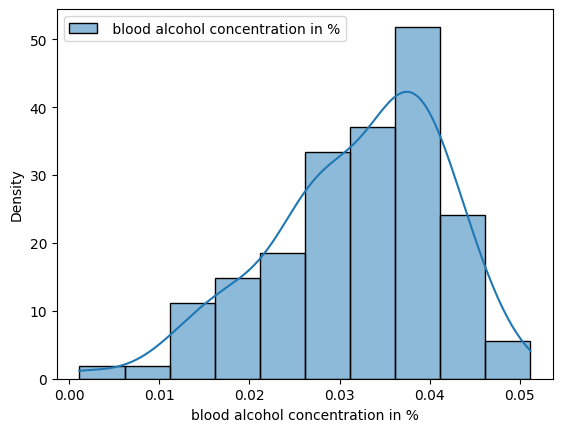

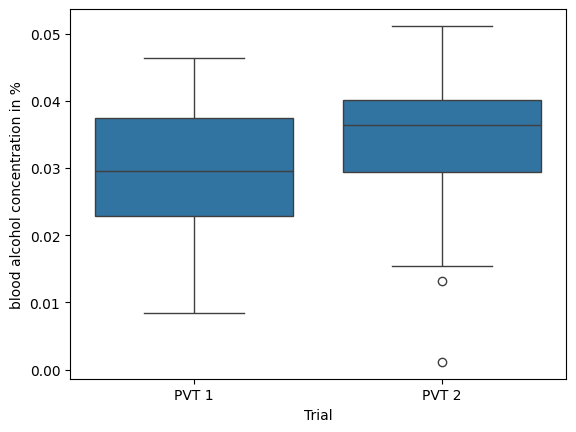

In [6]:
data_df = pl.DataFrame({'y': data['y'],
                       'subject':data['subjects'],
                       'condition':data['condition'],
                       'session_id':data['session_ids'],
                       'trial_id':data['trial_ids']})
data_bac_df = data_df.filter(pl.col('y') > 0)
bac_means = []
trials = []
trial_names = []
for g_name, g_data in data_bac_df.group_by(['subject','trial_id']):
    bac_means.append(np.mean(np.array(g_data['y'])))
    trials.append(np.mean(np.array(g_data['trial_id'])))
    if trials[-1] == 1.:
        trial_names.append('PVT 1')
    else:
        trial_names.append('PVT 2')
import seaborn as sns

sns.histplot(bac_means, label=' blood alcohol concentration in %', stat='density', kde = True)
plt.xlabel('blood alcohol concentration in %')
plt.legend()
plt.savefig(plot_dir + 'bac_density.pdf', dpi=300)
plt.show()

sort_ids = np.argsort(np.array(trial_names))[:-1]

sns.boxplot(pl.DataFrame({'blood alcohol concentration in %':np.array(bac_means)[sort_ids],
                         'Trial':np.array(trial_names)[sort_ids]}),x='Trial', y = 'blood alcohol concentration in %')
plt.savefig(plot_dir + 'bac_boxplot.pdf', dpi=300)
plt.show()

In [7]:
len(np.unique(data['subjects']))

57

In [8]:
basics = pl.read_csv('/mnt/mlshare/ds/data/questionnaires/results/basic.csv')
basics

subject_id,session_id,age,gender,mother_tongue,handedness,eyesight,astigmatism,optical aids,previous_exp_here,previous_experiment_other
i64,i64,f64,str,str,str,str,str,str,str,str
1,1,26.0,"""woman""","""deutsch""","""right-handed""","""no""","""No""","""no""","""Yes""","""Yes"""
2,1,19.0,"""woman""","""deutsch""","""right-handed""","""no""","""No""","""no""","""No""","""No"""
3,1,22.0,"""woman""","""Deutsch, persisch""","""right-handed""","""no""","""No""","""no""","""No""","""No"""
4,1,19.0,"""man""","""Deutsch""","""right-handed""","""no""","""No""","""no""","""No""","""No"""
5,1,32.0,"""man""","""deutsch""","""right-handed""","""shortsighted""","""No""","""soft lenses""","""No""","""No"""
…,…,…,…,…,…,…,…,…,…,…
54,2,22.0,"""woman""","""deutsch""","""right-handed""","""no""","""No""","""no""","""No""","""No"""
57,2,25.0,"""man""","""Englisch ""","""right-handed""","""no""","""No""","""no""","""No""","""No"""
58,2,22.0,"""man""","""deutsch""","""right-handed""","""no""","""No""","""no""","""Yes""","""No"""


In [9]:
subjects = np.array(data_df['subject'])
u_subjects = list(np.unique(subjects))
gender = []
age = []
for i in range(len(u_subjects)):
    cur_sub = u_subjects[i]
    filter_data = basics.filter(pl.col('subject_id') == cur_sub)
    #if filter_data.shape[0] == 0:
    #    pass
    try:
        cur_age = np.float32(filter_data['age'][0])
    except:
        cur_age = np.nan
    age.append(cur_age)
    try:
        cur_gender = str(filter_data['gender'][0])
    except:
        cur_gender = np.nan
    gender.append(cur_gender)

In [10]:
len(gender)

57

In [11]:
np.unique(gender, return_counts=True)

(array(['diverse, non-binary, or other', 'man', 'nan', 'woman'],
       dtype='<U32'),
 array([ 1, 26,  3, 27]))

In [12]:
pl.DataFrame(age).describe()

statistic,column_0
str,f64
"""count""",57.0
"""null_count""",0.0
"""mean""",NaN
"""std""",NaN
"""min""",18.0
"""25%""",21.0
"""50%""",22.0
"""75%""",25.0
"""max""",62.0


In [13]:
np.nanmean(age)

np.float64(23.5)

In [14]:
np.nanstd(age)

np.float64(6.244256620346472)

closed-population (time-split)
All features & 0.901 $\pm$ 0.012*\\
W/O pupil features & 0.88 $\pm$ 0.015*\\
W/O closure feature & 0.885 $\pm$ 0.013*\\
Only eye movements & 0.874 $\pm$ 0.013*\\
Only pupil features & 0.697 $\pm$ 0.013*\\
Only closure features & 0.702 $\pm$ 0.017*\\


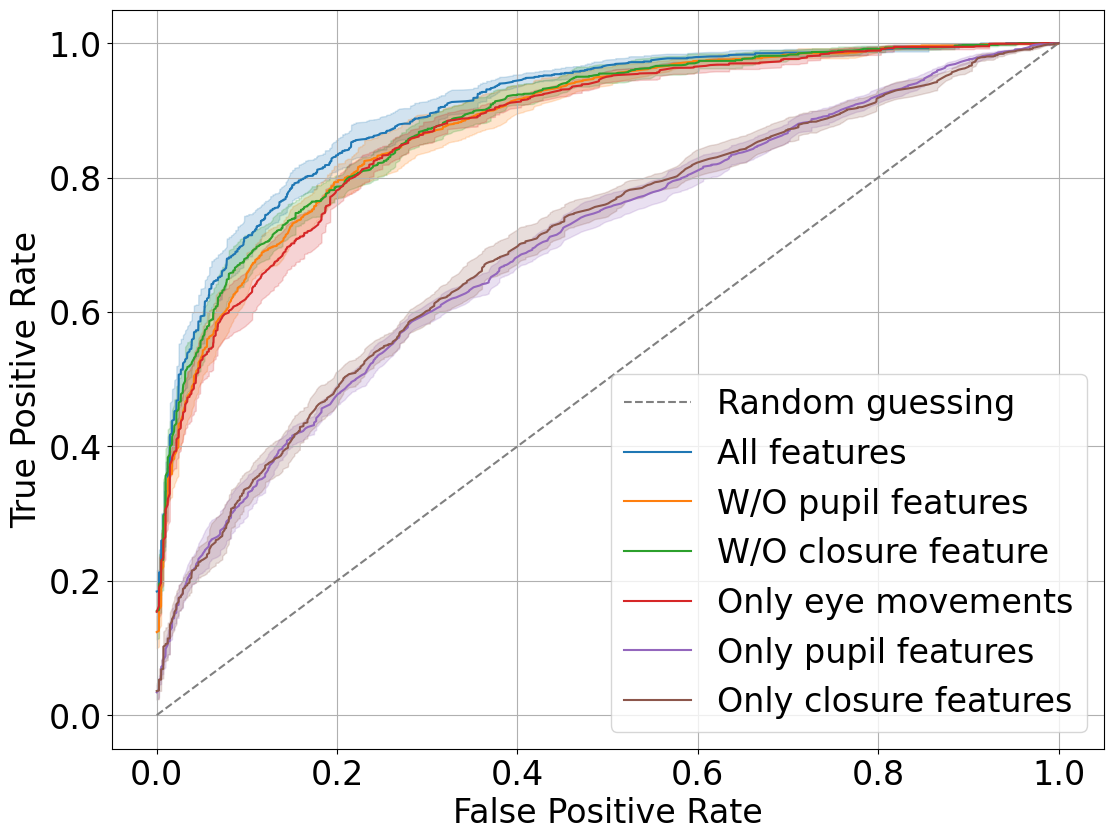

closed-population (trial-split)
All features & 0.669 $\pm$ 0.008*\\
W/O pupil features & 0.65 $\pm$ 0.008*\\
W/O closure feature & 0.657 $\pm$ 0.005*\\
Only eye movements & 0.627 $\pm$ 0.004*\\
Only pupil features & 0.605 $\pm$ 0.006*\\
Only closure features & 0.596 $\pm$ 0.001*\\


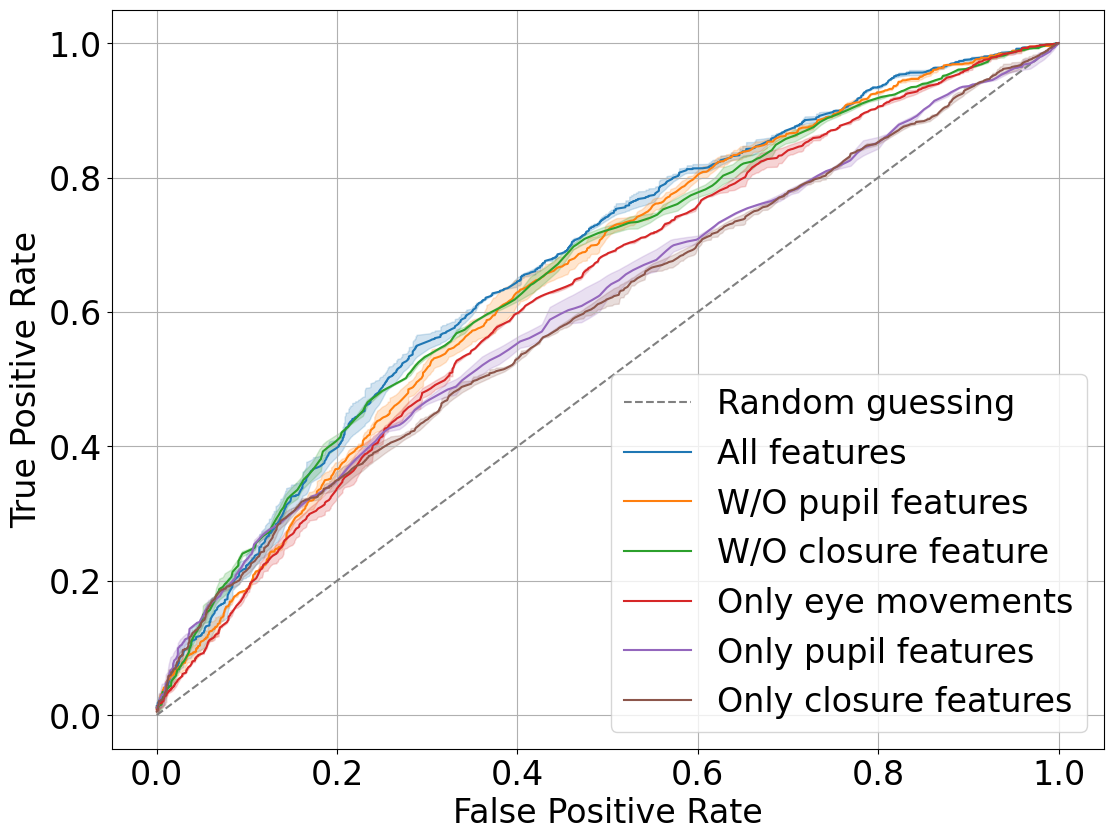

open-population
All features & 0.578 $\pm$ 0.012*\\
W/O pupil features & 0.554 $\pm$ 0.01*\\
W/O closure feature & 0.567 $\pm$ 0.015*\\
Only eye movements & 0.559 $\pm$ 0.014*\\
Only pupil features & 0.532 $\pm$ 0.016\\
Only closure features & 0.532 $\pm$ 0.018\\


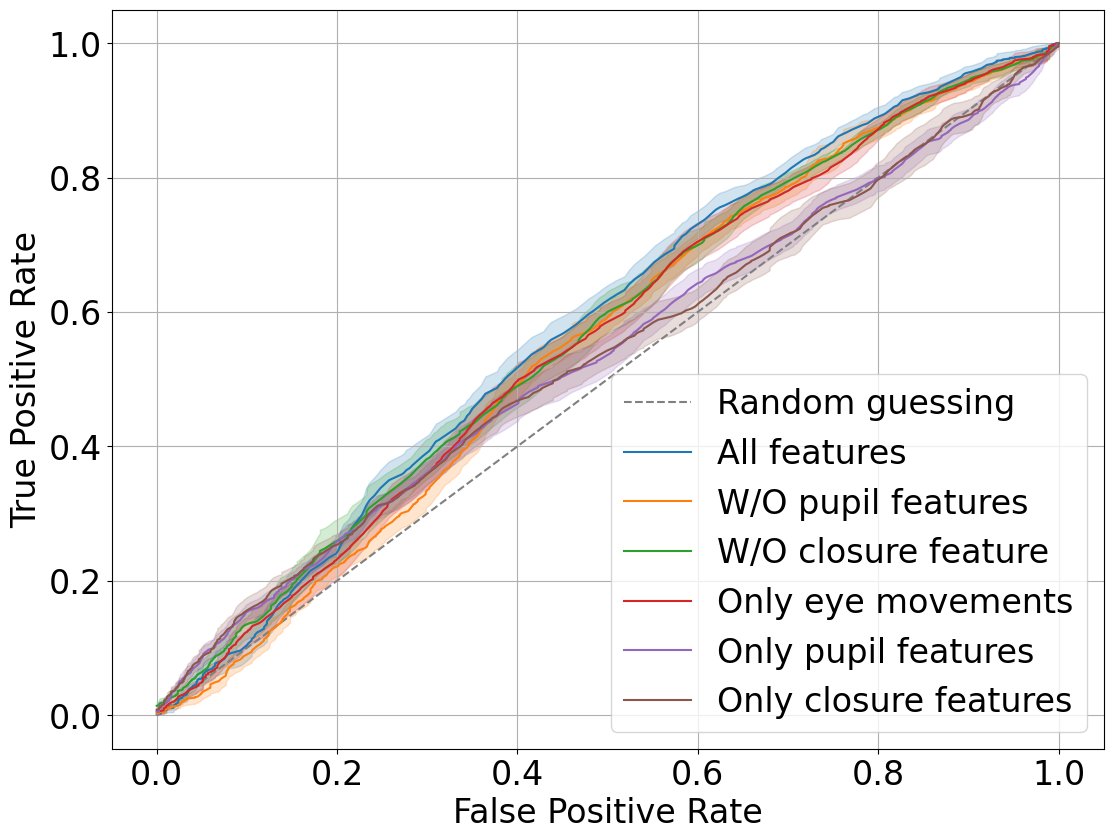

In [15]:
scale_factor = 2
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf'
        joblib_path = cur_load_path + '.joblib'
        csv_path = cur_load_path + '.csv'
        cur_data = joblib.load(joblib_path)
        cur_df = pl.read_csv(csv_path)
        if j == 0:
            plot_random = True
        else:
            plot_random = False
        cur_aucs = np.array(cur_df[use_metric])
        better_random_pvalue = ttest_1samp(a=cur_aucs,popmean=0.5,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        table_str = cur_feature_name + ' & ' + str(np.round(np.mean(cur_aucs), decimals)) + ' $\\pm$ ' +\
                        str(np.round(np.std(cur_aucs) / np.sqrt(len(cur_aucs)), decimals)) + cur_p_value_add_str + '\\\\'
        print(table_str)
        avg_tpr_fpr_curve(cur_data[fpr], cur_data[tpr], cur_feature_name, plot_random=plot_random,
                          plot_statistics=False, fontsize = 24, loc='lower right', color=cur_feature_color)
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_auc.pdf', dpi=300)
    plt.show()

### Plots for BAC levels

closed-population (time-split)


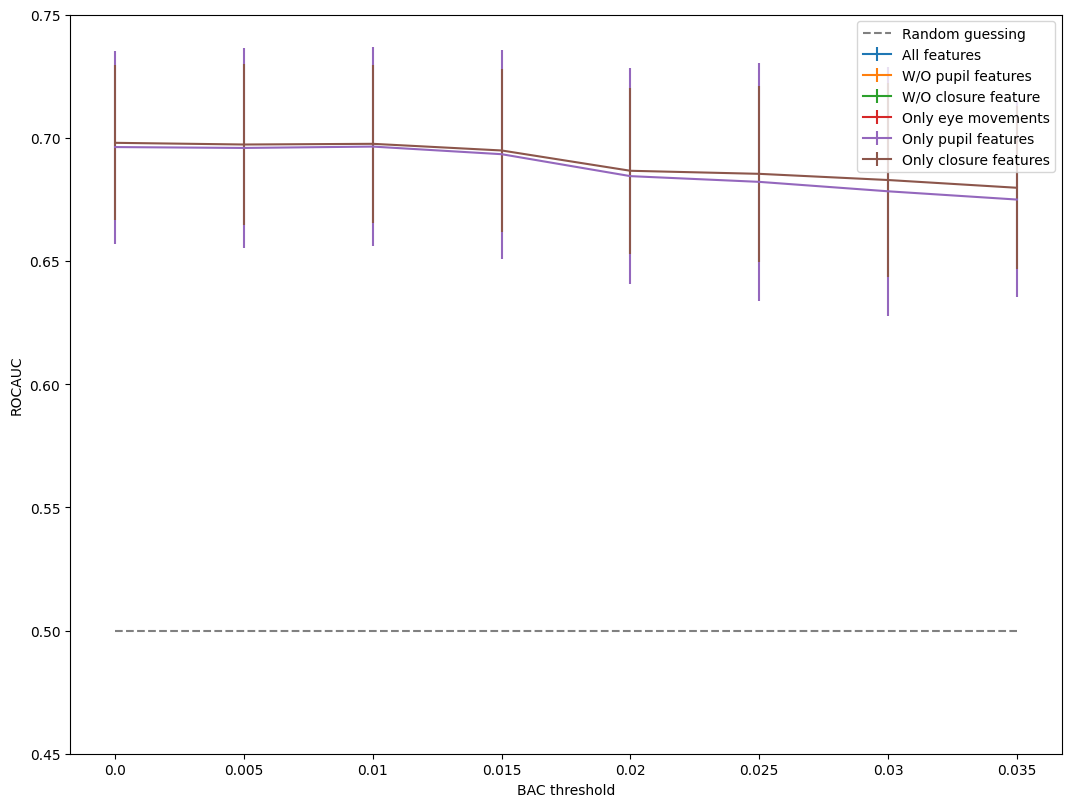

closed-population (trial-split)


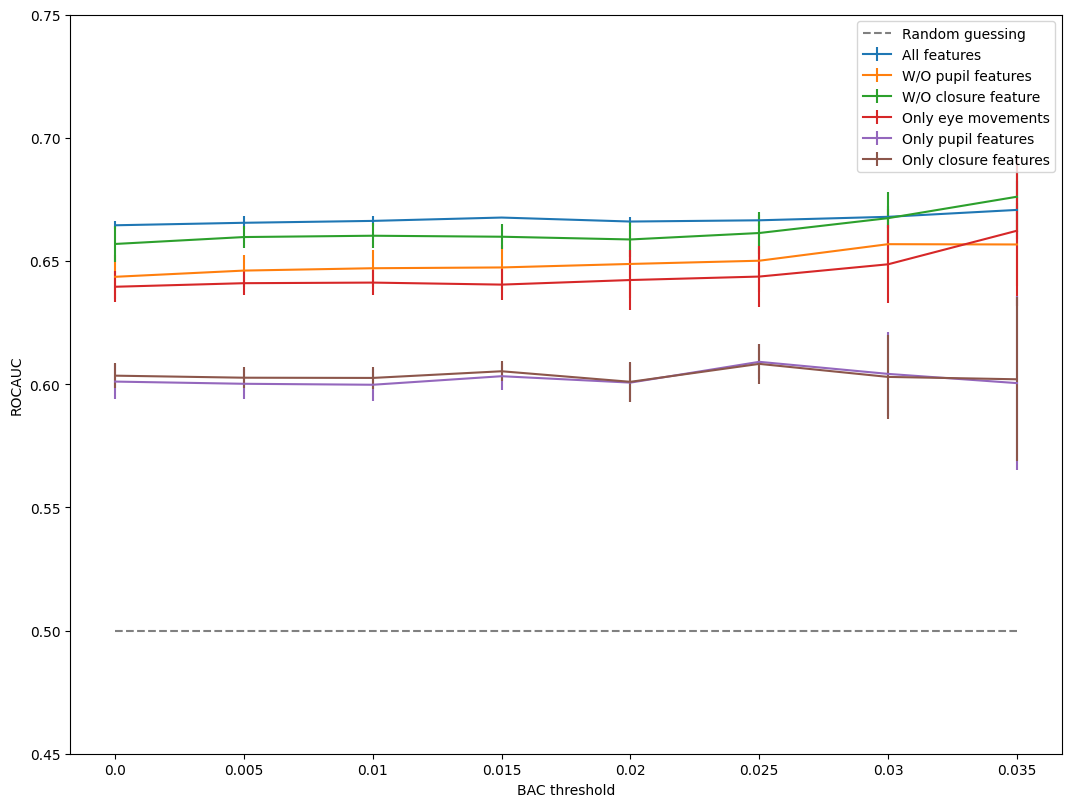

open-population


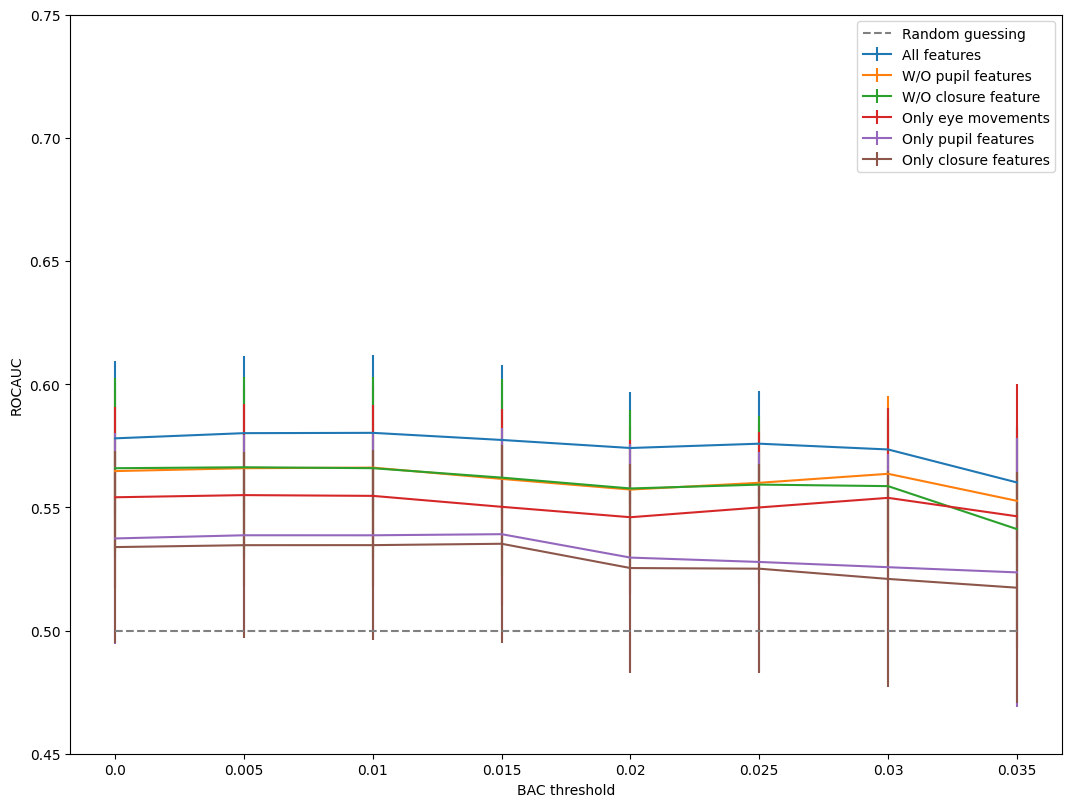

In [16]:
scale_factor = 2
bac_threshold = 0.0
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        if not os.path.exists(joblib_path):
            print('skip: ' + str(joblib_path))
            continue
        cur_data = joblib.load(joblib_path)

        bac_levels = np.arange(0,0.04,0.005)
        num_folds = len(cur_data['fold_dicts'])
        auc_matrix = np.zeros([len(bac_levels), num_folds])
        
        for b_i in range(len(bac_levels)):
            bac_level = bac_levels[b_i]
            for fold_i in range(num_folds):
                cur_fold_data = cur_data['fold_dicts'][fold_i]
                neg_ids = np.where(cur_fold_data['y_test_bac'] == 0)[0]
                pos_ids = np.where(cur_fold_data['y_test_bac'] > bac_level)[0]
                use_ids = np.concatenate([neg_ids, pos_ids])
                fpr, tpr, _ = metrics.roc_curve(cur_fold_data['y_test'][use_ids], cur_fold_data['predictions'][use_ids], pos_label=1)
                auc = metrics.auc(fpr, tpr)
                auc_matrix[b_i, fold_i] = auc
        plt.errorbar(np.arange(len(bac_levels)), np.mean(auc_matrix, axis=1), np.std(auc_matrix, axis=1),
                    label=cur_feature_name, color=cur_feature_color)
    plt.plot(np.arange(len(bac_levels)),[0.5 for _ in np.arange(len(bac_levels))], color='grey', linestyle='dashed',
                 label='Random guessing')
    plt.xlabel('BAC threshold')
    plt.ylabel('ROCAUC')
    plt.xticks(np.arange(len(bac_levels)),bac_levels)
    plt.legend()
    plt.ylim([0.45,0.75])
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_bac_levels.pdf', dpi=300)
    plt.show()

### Boxplot for subject specific ROCAUC's

closed-population (time-split)


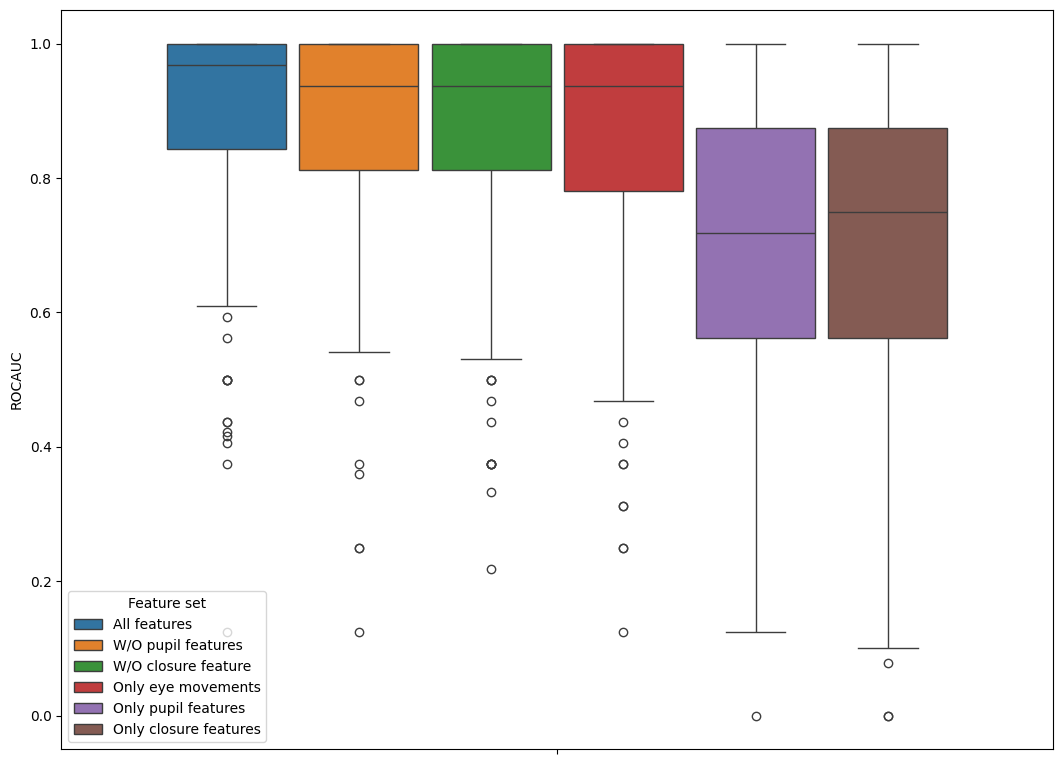

closed-population (trial-split)


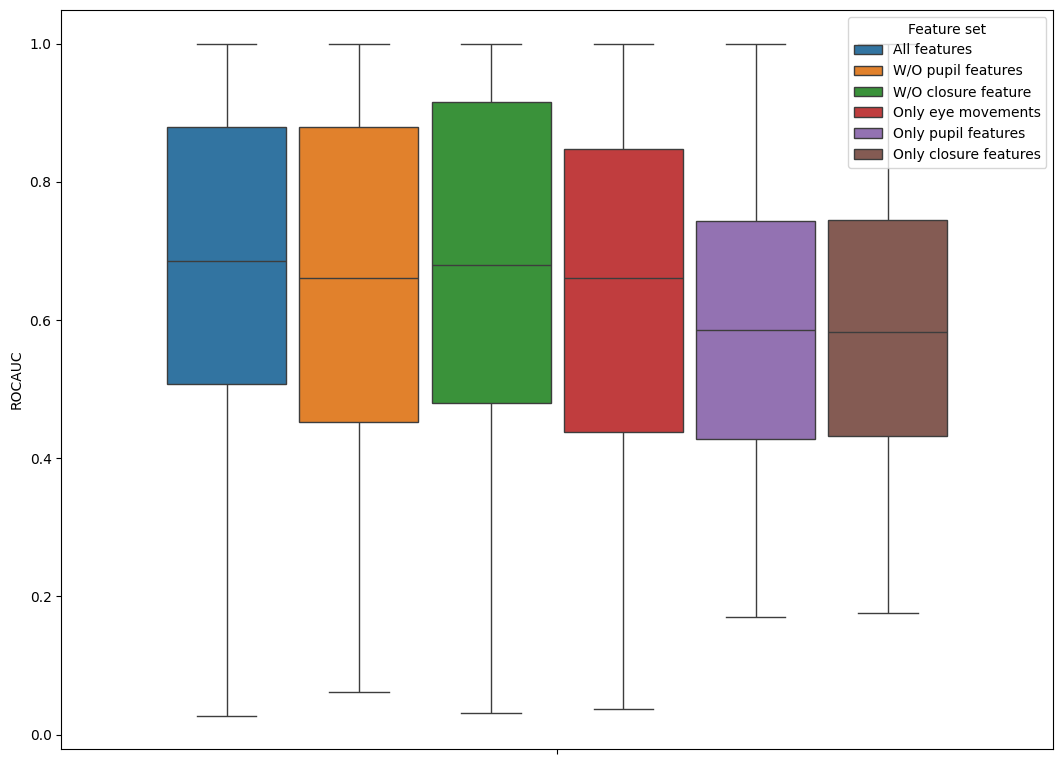

open-population


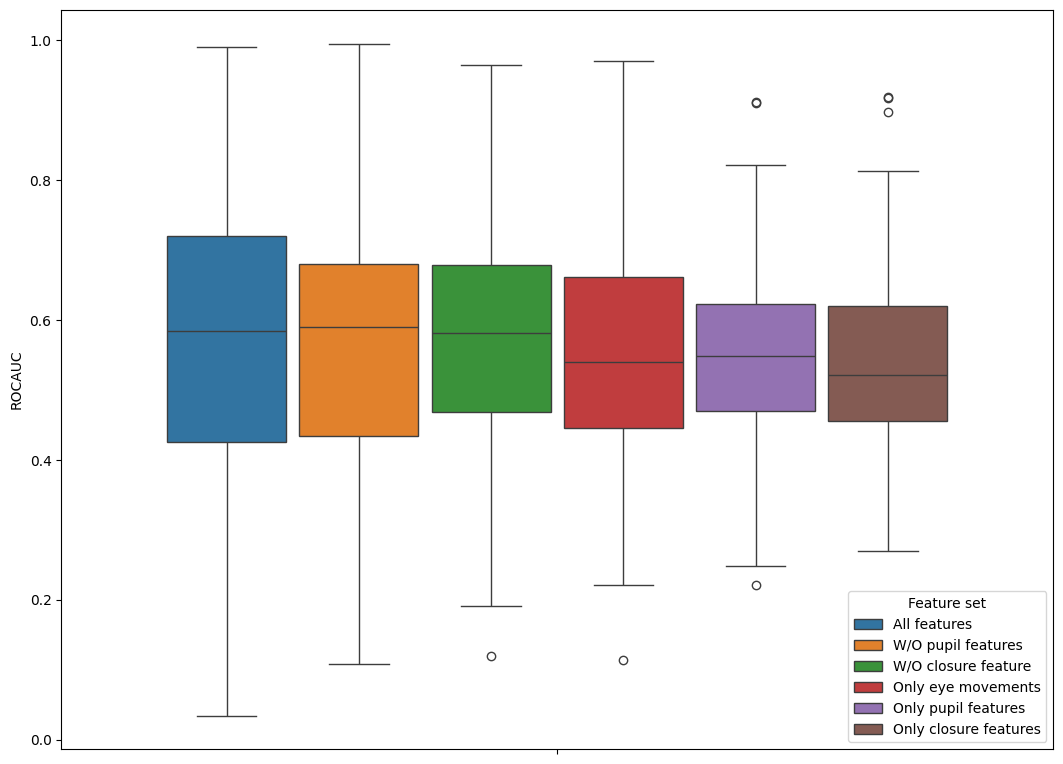

In [17]:
scale_factor = 2
bac_threshold = 0.0
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    auc_values = []
    feature_values = []
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        if not os.path.exists(joblib_path):
            print('skip: ' + str(joblib_path))
            continue
        cur_data = joblib.load(joblib_path)
        num_folds = len(cur_data['fold_dicts'])
        
        subject_aucs = []
        for fold_i in range(num_folds):
            cur_fold_data = cur_data['fold_dicts'][fold_i]
            fold_subjects = cur_fold_data['subjects_test']
            unique_subjects = list(np.unique(fold_subjects))
            for s_i in range(len(unique_subjects)):
                c_subject = unique_subjects[s_i]
                c_ids = np.where(np.array(fold_subjects) == c_subject)[0]
                if len(np.unique(cur_fold_data['y_test'][c_ids])) == 1:
                    continue
                fpr, tpr, _ = metrics.roc_curve(cur_fold_data['y_test'][c_ids], cur_fold_data['predictions'][c_ids], pos_label=1)
                auc = np.float32(metrics.auc(fpr, tpr))
                subject_aucs.append(auc)
                auc_values.append(auc)
                feature_values.append(cur_feature_name)
    box_data = pl.DataFrame({'ROCAUC': auc_values,
                             'Feature set': feature_values})
    #sns.boxplot(box_data,x='Feature set', y = 'ROCAUC', palette=my_pal)
    sns.boxplot(hue=box_data['Feature set'], y=box_data['ROCAUC'], palette=my_pal, gap=0.1)
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_box_subject_aucs.pdf', dpi=300)
    plt.show()